Aim: Run random projection on pbmc dataset and test using scanpy and etm-dense pipeline.


In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging

In [2]:
experiment = '/projects/experiments/fastsca/'
# experiment = sys.argv[1]

server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

Create an object to read data (scipy csr format).

In [3]:
sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
sca.loaddata()

## Random Projection

Johnson-Lindenstrauss Lemma-
The distance between two points in a high-dimension data is approximately preserved when projected onto a randomly selected subspace of suitable dimension.

$$X_{k \times N}^{RP} =  R_{k \times d} X_{d \times N}$$

Complexity : RP vs PCA
$$O(kdN)$$
$$O(d^{2}N + d^{3}+ kdN)$$

Non orthogonal transformation can significantly distort data.

R is generally not orthogonal and computation to orthogonalize R is expensive.

Hecht-Nielsen study - 
In a high-dimensional space, there exists a much larger number of almost orthogonal than orthogonal directions. Vectors having random directions might be sufficiently close to orthogonal.

$$R^{T}R \sim I$$

How to calculate number of reduced dimension:
$$k>ln(N)/ \epsilon^{2}$$

Gaussian random projection: $N(0,1/k)$



In [4]:
from sklearn import random_projection
from sklearn.preprocessing import StandardScaler

print(sca.data.mtx.shape)
transformer = random_projection.GaussianRandomProjection(eps=0.1)
x_r_n = transformer.fit_transform(np.asarray(sca.data.mtx))
print(x_r_n.shape)

# scaling data to zero mean and unit variance
scaler = StandardScaler()
x_r_n = scaler.fit_transform(x_r_n)

(2700, 13745)
(2700, 6772)


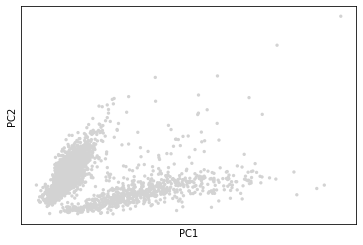

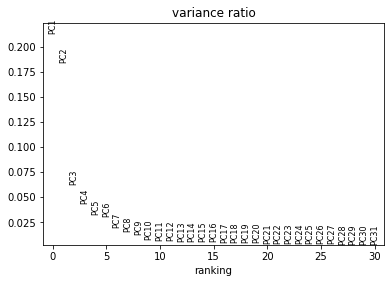

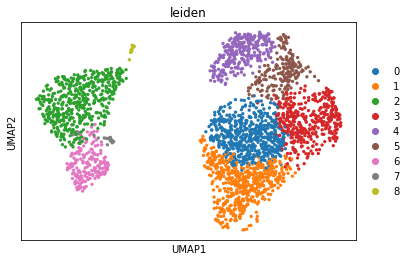

In [15]:
import anndata
import scanpy as sc
import matplotlib.pylab as plt

adata = anndata.AnnData(x_r_n)
adata.obs = pd.DataFrame(sca.data.rows)

sc.tl.pca(adata, svd_solver='arpack',n_comps=100)
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata)

sc.pp.neighbors(adata,n_neighbors=10, n_pcs=100)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.6)
sc.pl.umap(adata, color=['leiden'])

Compare RP data clustering with the original scanpy pipeline result- https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden_original' as categorical


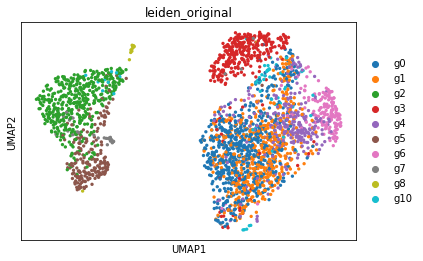

In [16]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

dfp = pd.read_csv(fpath+'_prior_label.csv.gz')

#merge original leiden calls to adata. Original data donot have all 2700 cells because of filtering step.
d = dict(zip(dfp.iloc[:,0], dfp['leiden']))
t=[]
for x in adata.obs.iloc[:,0].values: 
    if x in d.keys(): t.append(d[x])
    else:t.append(10)# just assign 10 for filtered out cells in original 

adata.obs['leiden_original'] = [ 'g'+str(x) for x in t]
sc.pl.umap(adata, color=['leiden_original'])

Test RP data with etm-dense model.

In [10]:
# prepare data for etm-dense module

import scipy
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id+'_rp'
smat = scipy.sparse.csr_matrix(x_r_n)
np.save(fpath+'.indptr',smat.indptr)
np.save(fpath+'.indices',smat.indices)
np.save(fpath+'.data',smat.data)

In [11]:
from topicmodel import scetm, _runner_etm
print(fpath)

rp_etm = scetm.SCETM()
rp_etm.data.mtx_indptr = fpath+'.indptr.npy'
rp_etm.data.mtx_indices = fpath+'.indices.npy'
rp_etm.data.mtx_data = fpath+'.data.npy'
rp_etm.data.rows = list(pd.read_csv(fpath + '.rows.csv.gz')['rows']) 
rp_etm.data.cols = list([ 'c'+str(i) for i in range(x_r_n.shape[1])]) 
rp_etm.etm.model_id = fpath

/home/BCCRC.CA/ssubedi/projects/experiments/fastsca/result/pbmc/pbmc_rp


In [ ]:
_runner_etm.run_model(rp_etm,fpath,'train')

In [ ]:
2022-10-28 13:09:06 INFO     Starting ETM dense model train...
batch_size : 32
l_rate : 0.0001
epochs : 100
layers : [200, 100, 10]
latent_dims : 10
device : cuda:1

2022-10-28 13:09:06 INFO     Input dimension is 6772
2022-10-28 13:09:07 INFO     ETM(
  (encoder): ETMEncoder(
    (fc): Stacklayers(
      (layers): ModuleList(
        (0): Linear(in_features=6772, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
        (3): ReLU()
        (4): Linear(in_features=100, out_features=10, bias=True)
        (5): ReLU()
      )
    )
    (z_mean): Linear(in_features=10, out_features=10, bias=True)
    (z_lnvar): Linear(in_features=10, out_features=10, bias=True)
    (log_softmax): LogSoftmax(dim=-1)
  )
  (decoder): ETMDecoder(
    (lsmax): LogSoftmax(dim=-1)
  )
)
2022-10-28 13:09:07 INFO     Starting training....
2022-10-28 13:09:10 INFO     ====> Epoch: 0 Average loss: -3141.5171
2022-10-28 13:09:11 INFO     ====> Epoch: 1 Average loss: -3134.3139
2022-10-28 13:09:13 INFO     ====> Epoch: 2 Average loss: -3123.0688
2022-10-28 13:09:15 INFO     ====> Epoch: 3 Average loss: nan
2022-10-28 13:09:17 INFO     ====> Epoch: 4 Average loss: nan
2022-10-28 13:09:19 INFO     ====> Epoch: 5 Average loss: nan
2022-10-28 13:09:20 INFO     ====> Epoch: 6 Average loss: nan
2022-10-28 13:09:22 INFO     ====> Epoch: 7 Average loss: nan


Result:

1. scanpy - RP does not seem to distort data heavily as clustering is fairly similar to the original result. It will be interesting to test if this result improves or worsens with large dataset ( rows in millions). 
2. etm - training did not work because of nan after few epochs. Tried gradient clipping, leakyrelu(), weight decay, and various combination of normalization techniques. 